<a href="https://colab.research.google.com/github/aumkeshchaudhary/AIRL_IISc/blob/main/q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installation

!pip install git+https://github.com/facebookresearch/segment-anything-2.git -q
!pip install supervision transformers groundingdino-py -q
!pip install opencv-python matplotlib pillow numpy torch torchvision -q

# Downloding model checkpoints

!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt
!wget -q https://raw.githubusercontent.com/IDEA-Research/GroundingDINO/main/groundingdino/config/GroundingDINO_SwinT_OGC.py
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 7.0 MB/s eta 0:00:00


In [9]:
# Imorts

import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import supervision as sv
from groundingdino.util.inference import load_model, predict
from sam2.build_sam import build_sam2, build_sam2_video_predictor
from sam2.sam2_image_predictor import SAM2ImagePredictor
import warnings
warnings.filterwarnings('ignore')

In [10]:
# Initialize model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load GroundingDINO
grounding_model = load_model(
    model_config_path="GroundingDINO_SwinT_OGC.py",
    model_checkpoint_path="groundingdino_swint_ogc.pth",
    device=device
)

# Load SAM 2
sam2_checkpoint = "sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
sam2_predictor = SAM2ImagePredictor(sam2_model)

print(" Models loaded!")

Using device: cuda
final text_encoder_type: bert-base-uncased
 Models loaded!


In [11]:
# Helper functions

def load_image(image_path, max_size=1024):
    if image_path.startswith('http'):
        import requests
        from io import BytesIO
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(image_path).convert('RGB')

    # Resize image if it's larger than max_size
    if max(image.size) > max_size:
        ratio = max_size / max(image.size)
        new_size = (int(image.size[0] * ratio), int(image.size[1] * ratio))
        image = image.resize(new_size, Image.Resampling.LANCZOS)

    return np.array(image)


def detect_objects_with_grounding_dino(image, text_prompt, box_threshold=0.35, text_threshold=0.25):
    # Convert image to PyTorch tensor
    image_tensor = torch.from_numpy(image).permute(2, 0, 1).to(device) / 255.0

    boxes, logits, phrases = predict(
        model=grounding_model,
        image=image_tensor,
        caption=text_prompt,
        box_threshold=box_threshold,
        text_threshold=text_threshold,
        device=device
    )

    # Convert boxes to xyxy format
    h, w = image.shape[:2]
    boxes_xyxy = boxes * torch.tensor([w, h, w, h], device=boxes.device)

    return boxes_xyxy.cpu().numpy(), logits.cpu().numpy(), phrases

def segment_with_sam2(image, boxes):
    sam2_predictor.set_image(image)

    all_masks = []
    for box in boxes:
        masks, scores, _ = sam2_predictor.predict(
            point_coords=None,
            point_labels=None,
            box=box[None, :],
            multimask_output=False
        )
        all_masks.append(masks[0])

    return all_masks

def visualize_results(image, masks, boxes, phrases, text_prompt):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Original image
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Bounding boxes
    axes[1].imshow(image)
    for box, phrase in zip(boxes, phrases):
        x1, y1, x2, y2 = box
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                            fill=False, color='green', linewidth=2)
        axes[1].add_patch(rect)
        axes[1].text(x1, y1-5, phrase, color='white',
                    bbox=dict(boxstyle='round', facecolor='green', alpha=0.7))
    axes[1].set_title(f'Detected: "{text_prompt}"')
    axes[1].axis('off')

    # Segmentation masks overlay
    axes[2].imshow(image)
    combined_mask = np.zeros(image.shape[:2], dtype=bool)
    for mask in masks:
        combined_mask |= mask.astype(bool)

    overlay = np.zeros_like(image)
    overlay[combined_mask] = [0, 255, 0]
    axes[2].imshow(overlay, alpha=0.5)
    axes[2].set_title('SAM 2 Segmentation Mask')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    return combined_mask

def box_to_center_point(box):
    """Converts a bounding box [x1, y1, x2, y2] to its center point [cx, cy]."""
    x1, y1, x2, y2 = box
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    return np.array([[cx, cy]])

In [12]:
# Main pipeline


def text_driven_segmentation(image_path, text_prompt, box_threshold=0.35):
    print(f"\n{'='*60}")
    print(f"Text Prompt: '{text_prompt}'")
    print(f"{'='*60}\n")

    # Step 1: Load image
    print("[1/4] Loading image...")
    image = load_image(image_path)
    print(f"      Image shape: {image.shape}")

    # Step 2: Detect objects with GroundingDINO
    print("[2/4] Detecting objects with GroundingDINO...")
    boxes, logits, phrases = detect_objects_with_grounding_dino(
        image, text_prompt, box_threshold=box_threshold
    )
    print(f"      Found {len(boxes)} object(s): {phrases}")

    if len(boxes) == 0:
        print("\n⚠ No objects detected. Try lowering box_threshold")
        return None

    # Step 3: Segment with SAM 2
    print("[3/4] Generating masks with SAM 2...")
    masks = segment_with_sam2(image, boxes)
    print(f"      Generated {len(masks)} mask(s)")

    # Step 4: Visualize results
    print("[4/4] Visualizing results...")
    combined_mask = visualize_results(image, masks, boxes, phrases, text_prompt)

    print("\n✓ Segmentation complete!")

    return {
        'image': image,
        'masks': masks,
        'boxes': boxes,
        'phrases': phrases,
        'combined_mask': combined_mask
    }


Text Prompt: 'cat'

[1/4] Loading image...
      Image shape: (675, 1024, 3)
[2/4] Detecting objects with GroundingDINO...
      Found 1 object(s): ['cat']
[3/4] Generating masks with SAM 2...
      Generated 1 mask(s)
[4/4] Visualizing results...


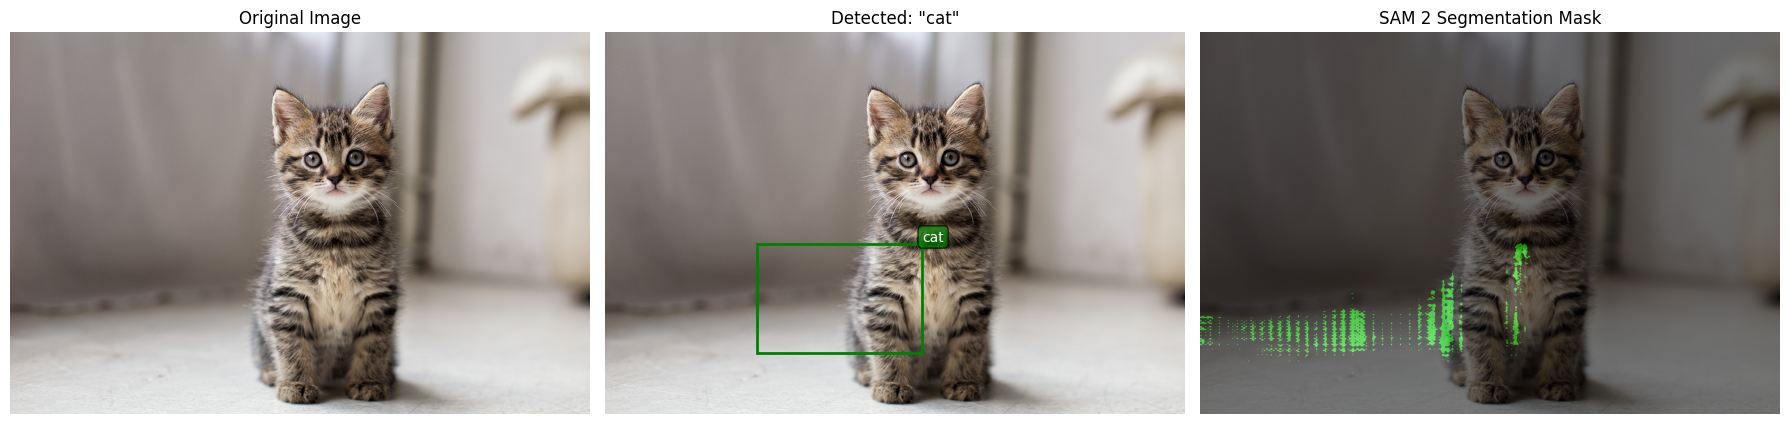


✓ Segmentation complete!


Saving cat.avif to cat (1).avif
Enter object to segment: cat

Text Prompt: 'cat'

[1/4] Loading image...
      Image shape: (819, 1024, 3)
[2/4] Detecting objects with GroundingDINO...
      Found 1 object(s): ['cat']
[3/4] Generating masks with SAM 2...
      Generated 1 mask(s)
[4/4] Visualizing results...


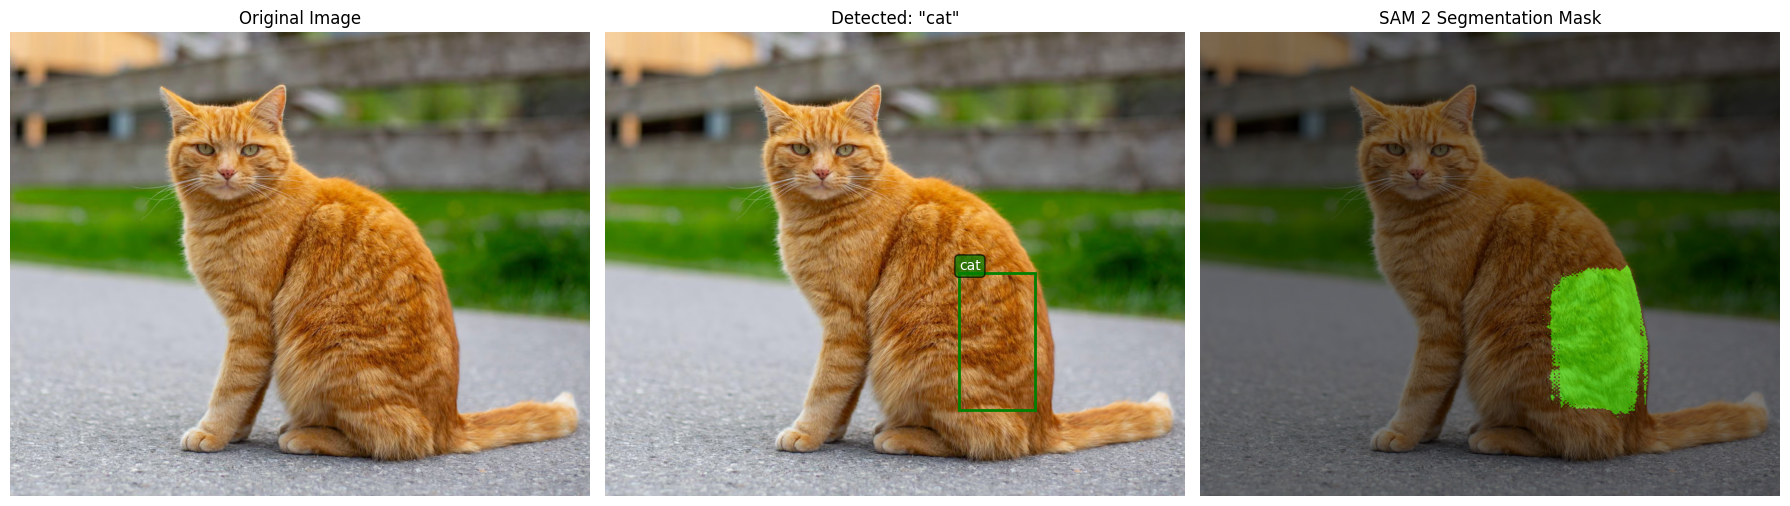


✓ Segmentation complete!


In [18]:
# Example usage

# Example 1: Segment a cat
image_url = "https://wpcdn.web.wsu.edu/news/uploads/sites/2797/2025/03/cat2.jpg"
text_prompt = "cat"
result = text_driven_segmentation(image_url, text_prompt)

# Example 2: Upload your own image
from google.colab import files
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
text_prompt = input("Enter object to segment: ")
result = text_driven_segmentation(image_path, text_prompt)

In [14]:
# Bonus: Video Segmentation

import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Utility: convert bounding box to center point
def box_to_center_point(box):
    x1, y1, x2, y2 = box
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    return np.array([[cx, cy]])

# Extract frames from video
def extract_video_frames(video_path, output_dir="frames"):
    Path(output_dir).mkdir(exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        cv2.imwrite(f"{output_dir}/{frame_count:05d}.jpg",
                   cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR))
        frame_count += 1

    cap.release()
    return frame_count, fps, output_dir

# Recreate video from frames
def create_video_from_frames(frame_dir, output_path, fps=30):
    frame_files = sorted(Path(frame_dir).glob("*.jpg"))

    if not frame_files:
        return None

    first_frame = cv2.imread(str(frame_files[0]))
    height, width = first_frame.shape[:2]

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for frame_file in frame_files:
        frame = cv2.imread(str(frame_file))
        out.write(frame)

    out.release()
    return output_path


# Main pipeline
def text_driven_video_segmentation(video_path, text_prompt, output_path="output_video.mp4"):
    print(f"\n{'='*60}")
    print(f"Video Segmentation - Text Prompt: '{text_prompt}'")
    print(f"{'='*60}\n")

    # Extract frames
    print("[1/6] Extracting video frames...")
    frame_count, fps, frame_dir = extract_video_frames(video_path)
    print(f"      Extracted {frame_count} frames at {fps} FPS")

    # Load first frame for object detection
    print("[2/6] Detecting object in first frame...")
    first_frame_path = f"{frame_dir}/00000.jpg"
    first_frame = load_image(first_frame_path)

    boxes, logits, phrases = detect_objects_with_grounding_dino(
        first_frame, text_prompt, box_threshold=0.35
    )

    if len(boxes) == 0:
        print("\n No objects detected in first frame!")
        return None

    print(f"      Found: {phrases[0]}")

    # Initialize video predictor
    print("[3/6] Initializing SAM 2 video predictor...")
    video_predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

    # Initialize inference state with offloading to CPU
    print("[4/6] Initializing inference state (offloading video to CPU)...")
    inference_state = video_predictor.init_state(video_path=frame_dir, offload_video_to_cpu=True)

    # Add prompt for first frame
    print("[5/6] Adding prompts for first frame...")
    _, out_obj_ids, out_mask_logits = video_predictor.add_new_points(
        inference_state=inference_state,
        frame_idx=0,
        obj_id=1,
        points=box_to_center_point(boxes[0]),
        labels=np.array([1])
    )

    # Propagate masks through video
    print("[6/6] Propagating masks through video...")
    video_segments = {}
    for out_frame_idx, out_obj_ids, out_mask_logits in video_predictor.propagate_in_video(inference_state):
        video_segments[out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
            for i, out_obj_id in enumerate(out_obj_ids)
        }

    # Create output frames with overlay
    print("[Creating output video frames...]")
    output_frame_dir = "output_frames"
    Path(output_frame_dir).mkdir(exist_ok=True)

    for frame_idx in range(frame_count):
        frame_path = f"{frame_dir}/{frame_idx:05d}.jpg"
        frame = cv2.imread(frame_path)

        if frame is None:
            print(f"[Warning] Could not read frame {frame_idx}, skipping...")
            continue

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        if frame_idx in video_segments:
            mask = video_segments[frame_idx].get(1)

            if mask is not None and mask.size > 0:
                if mask.ndim == 3 and mask.shape[0] == 1:
                    mask = mask[0]

                try:
                    target_size = (frame_rgb.shape[1], frame_rgb.shape[0])
                    mask_resized = cv2.resize(mask.astype(np.uint8), target_size, interpolation=cv2.INTER_NEAREST)

                    overlay = frame_rgb.copy()
                    overlay[mask_resized.astype(bool)] = (
                        overlay[mask_resized.astype(bool)] * 0.5 + np.array([0, 255, 0]) * 0.5
                    ).astype(np.uint8)
                    frame_rgb = overlay
                except Exception as e:
                    print(f"[Warning] Resize failed on frame {frame_idx}: {e}")
                    continue

        #  Save each processed frame (fixed indentation bug)
        cv2.imwrite(f"{output_frame_dir}/{frame_idx:05d}.jpg",
                    cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR))

    # Create final video
    output_video = create_video_from_frames(output_frame_dir, output_path, fps)

    print(f"\n Video segmentation complete!")
    print(f"  Output saved to: {output_video}")

    # Display sample frames safely
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    sample_frames = [0, frame_count//2, frame_count-1]

    for idx, frame_idx in enumerate(sample_frames):
        frame_path = f"{output_frame_dir}/{frame_idx:05d}.jpg"
        frame = cv2.imread(frame_path)

        if frame is None:
            print(f"[Warning] Sample frame {frame_idx} missing, skipping display.")
            continue

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        axes[idx].imshow(frame_rgb)
        axes[idx].set_title(f"Frame {frame_idx}")
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

    return output_video

Saving 3092-166221773_small.mp4 to 3092-166221773_small.mp4
Enter object to track: cat

Video Segmentation - Text Prompt: 'cat'

[1/6] Extracting video frames...
      Extracted 397 frames at 28 FPS
[2/6] Detecting object in first frame...
      Found: cat
[3/6] Initializing SAM 2 video predictor...
[4/6] Initializing inference state (offloading video to CPU)...


frame loading (JPEG): 100%|██████████| 397/397 [00:10<00:00, 37.01it/s]


[5/6] Adding prompts for first frame...
[6/6] Propagating masks through video...


propagate in video: 100%|██████████| 397/397 [06:23<00:00,  1.04it/s]


[Creating output video frames...]

 Video segmentation complete!
  Output saved to: output_video.mp4


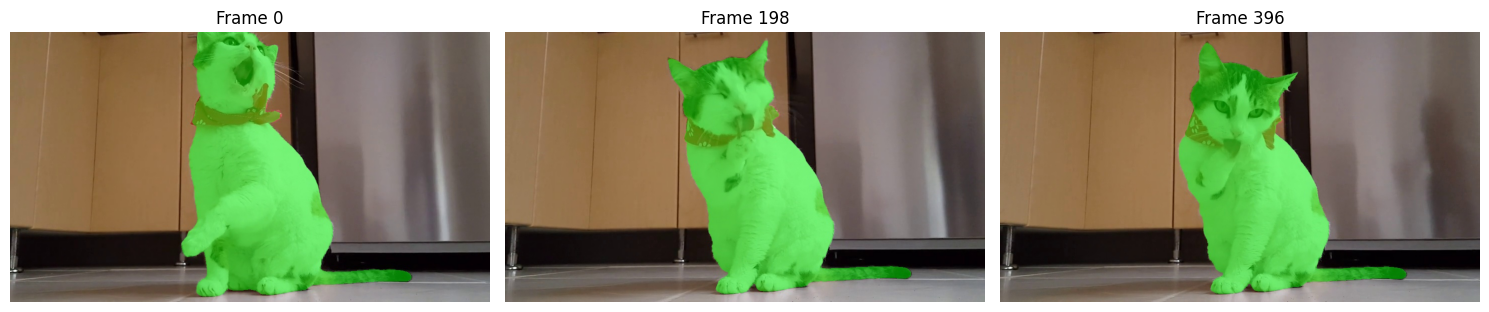

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
# Example - video

from google.colab import files

uploaded = files.upload()
video_path = list(uploaded.keys())[0]

text_prompt = input("Enter object to track: ")
output_video = text_driven_video_segmentation(video_path, text_prompt)

# Download result
if output_video:
    files.download(output_video)